In [1]:

import os
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [3]:
input_shape = (256, 256, 3)
data_dir = 'dataset'

real_data = [f for f in os.listdir(data_dir+'/real') if f.endswith('.jpg')]
fake_data = [f for f in os.listdir(data_dir+'/fake') if f.endswith('.jpg')]

print("Number of real images:", len(real_data))
print("Number of fake images:", len(fake_data))




X = []
Y = []

for img in real_data:
    X.append(img_to_array(load_img(data_dir+'/real/'+img)).flatten() / 255.0)
    Y.append(1)
for img in fake_data:
    X.append(img_to_array(load_img(data_dir+'/fake/'+img)).flatten() / 255.0)
    Y.append(0)

print("Shape of X before reshaping:", np.array(X).shape)
print("Shape of Y before one-hot encoding:", np.array(Y).shape)

Y_val_org = Y

#Normalization
X = np.array(X)
Y = to_categorical(Y, 2)

#Reshape
X = X.reshape(-1, 256, 256, 3)

print("Shape of X after reshaping:", X.shape)
print("Shape of Y after one-hot encoding:", Y.shape)



#Train-Test split
X_train_, X_val_, Y_train_, Y_val_ = train_test_split(X, Y, test_size=0.2, random_state=5)


Number of real images: 210
Number of fake images: 210
Shape of X before reshaping: (420, 196608)
Shape of Y before one-hot encoding: (420,)
Shape of X after reshaping: (420, 256, 256, 3)
Shape of Y after one-hot encoding: (420, 2)


In [4]:


from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

# Define input shape
input_shape = (256, 256, 3)  # Change dimensions according to your input images

# Create InceptionResNetV2 model
googleNet_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
googleNet_model.trainable = True

# Create a Sequential model
model = Sequential()

# Add InceptionResNetV2 model to the Sequential model
model.add(googleNet_model)

# Add GlobalAveragePooling2D layer
model.add(GlobalAveragePooling2D(input_shape=googleNet_model.output_shape[1:]))

# Add Dense layer with softmax activation for classification
model.add(Dense(units=2, activation='softmax'))

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
              metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 6, 6, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2)                 3074      
                                                                 
Total params: 54339810 (207.29 MB)
Trainable params: 54279266 (207.06 MB)
Non-trainable params: 60544 (236.50 KB)
_________________________________________________________________


In [6]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=2,
                               verbose=0, mode='auto')
EPOCHS = 10
BATCH_SIZE = 20

history = model.fit(X_train_, Y_train_, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_val_, Y_val_), verbose = 1)



Epoch 1/10
17/17 [==============================] - 109s 6s/step - loss: 0.5544 - accuracy: 0.7351 - val_loss: 161.8521 - val_accuracy: 0.5476
Epoch 2/10
17/17 [==============================] - 137s 8s/step - loss: 0.3440 - accuracy: 0.8720 - val_loss: 121.7382 - val_accuracy: 0.5476
Epoch 3/10
17/17 [==============================] - 168s 10s/step - loss: 0.1803 - accuracy: 0.9315 - val_loss: 3.4959 - val_accuracy: 0.5476
Epoch 4/10
17/17 [==============================] - 180s 11s/step - loss: 0.0632 - accuracy: 0.9821 - val_loss: 4.2549 - val_accuracy: 0.6548
Epoch 5/10
17/17 [==============================] - 146s 9s/step - loss: 0.1203 - accuracy: 0.9583 - val_loss: 1.3916 - val_accuracy: 0.6548
Epoch 6/10
17/17 [==============================] - 122s 7s/step - loss: 0.1976 - accuracy: 0.9315 - val_loss: 2.2491 - val_accuracy: 0.6548
Epoch 7/10
17/17 [==============================] - 118s 7s/step - loss: 0.0951 - accuracy: 0.9613 - val_loss: 0.7201 - val_accuracy: 0.8095
Epoch 8

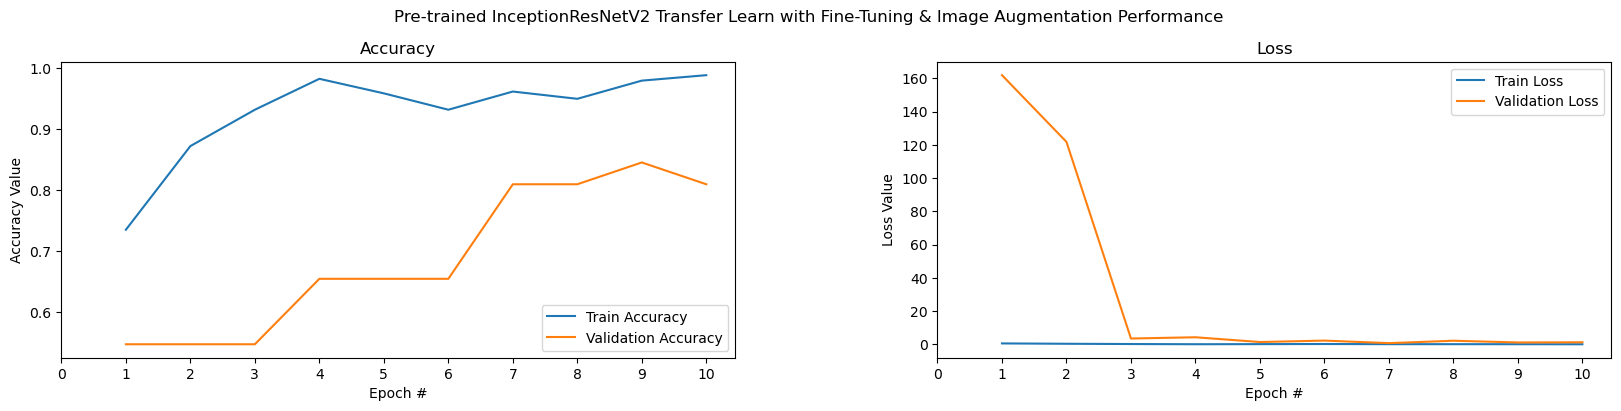

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pre-trained InceptionResNetV2 Transfer Learn with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

14/14 [==============================] - 35s 2s/step
True positive =  205
False positive =  5
False negative =  40
True negative =  170




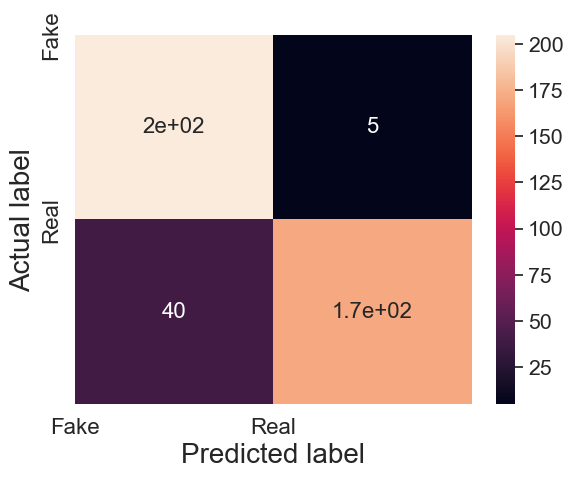

In [9]:
#Output confusion matrix


# Define a function to print confusion matrix
def print_confusion_matrix(y_true, y_pred):
    # Get the confusion matrix
    cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
    
    # Print true positives, false positives, false negatives, true negatives
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    
    # Plot confusion matrix
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()

# Assuming Y_val_org and X are defined elsewhere in your code
# Y_val_org: true labels
# X: input data

# Predict probabilities for each class
y_pred_prob = model.predict(X)

# Print confusion matrix
print_confusion_matrix(Y_val_org, y_pred_prob)
